In [1]:
import cudf
from cuml.manifold.umap import UMAP as cumlUMAP

In [2]:
!pip install kneed kneebow boto3 seaborn plotly pandas==0.24.2 scikit-learn==0.23.1

In [3]:
#imports:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import numba.targets
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [4]:
import boto3

bucket_name = 'hezi-sagemaker'
INPUT_DIR = 'neurosteer/data/sleep_data/'

cred = boto3.Session().get_credentials()
ACCESS_KEY = cred.access_key
SECRET_KEY = cred.secret_key

s3 = boto3.resource('s3', region_name='us-east-2')
bucket = s3.Bucket(bucket_name)

s3client = boto3.client('s3', 
            aws_access_key_id = ACCESS_KEY, 
            aws_secret_access_key = SECRET_KEY
           )

In [5]:
class sleep_clustering:

    def load_data(self,df,label_df,train_ids,test_id):
        self.train = np.zeros((1,121)) 
        sessionNames_list = df.index.levels[0]
        for i in train_ids:
            idx=i
            sessionName = sessionNames_list[idx]
            samples = filter_by(df,{'sessionName' : [sessionName]})
            samples = samples.to_numpy()
            self.train = np.concatenate((self.train,samples),axis=0)
        idx=test_id
        sessionName = sessionNames_list[idx]
        self.test = filter_by(df,{'sessionName' : [sessionName]}).to_numpy()
        label = filter_by(label_df,{'sessionName' : [sessionName]}).reset_index()
        self.labels = label.y
        self.labels.replace(['U','W','R','N2','N3'],[-1,3,2,1,0])
        self.labels_ts = labels.timestamp
    
    
    def fit(self, params):
        pca_components = params[0]
        remove_pc = params[1]
        umap_min_dist = params[2]
        umap_n_neighbors = params[3]
        umap_n_components = params[4]
        umap_low_memory = params[5]
        dbscan_eps = params[6]
        dbscan_min_samples = params[7]
        #random_state = params[8];
        
        self.pca = PCA(n_components=pca_components)
        self.umap_reducer = cumlUMAP(n_neighbors=umap_n_neighbors,
                                 min_dist=umap_min_dist,
                                 n_components=umap_n_components,
                                 #random_state=random_state,
                                 low_memory=umap_low_memory,
                                 verbose=True)
        self.db = DBSCAN(eps=dbscan_eps,min_samples=dbscan_min_samples)
                                   
        if pca_components>0:
            S1 = self.pca.fit_transform(self.train)
        else:
            S1 = self.train
        if remove_pc:
            S2 = S1[:,1:]
        else:
            S2 = S1                      
        
        self.S3 = self.umap_reducer.fit_transform(S2)                           
        self.S4 = self.db.fit(self.S3)
    
    def predict(self,test,params):
        pca_components = params[0]
        remove_pc = params[1]
        if pca_components>0:
            S1 = self.pca.transform(test)
        else:
            S1 = test
        if remove_pc:
            S2 = S1[:,1:]
        else:
            S2 = S1                      
        
        S3 = self.umap_reducer.transform(S2)                           
        S4 = self.db.fit(S3)
        return S4.labels_
    
    def transform(self,test,params):
        pca_components = params[0]
        remove_pc = params[1]
        if pca_components>0:
            S1 = self.pca.transform(test)
        else:
            S1 = test
        if remove_pc:
            S2 = S1[:,1:]
        else:
            S2 = S1                      
        
        S3 = self.umap_reducer.transform(S2)                           
        return S3                         
        
    def plot_projection(self, projection, colors=None):
        #if colors==None:
        #    colors=1;
        plt.figure(figsize=(15,5))
        plt.scatter(projection[:, 0], projection[:, 1],c=colors,s=3)
        plt.gca().set_aspect('equal', 'datalim')
        plt.legend(colors)

    def plot_heatmap(self,data):
        plt.figure(figsize=(15,5))
        ax = sns.heatmap(data.T,cmap='jet',cbar=False) #,vmin=-5,vmax=5)

    def plot_hypnogram(self,labels,timestamp=None):
        #for i in np.arange(len(labels)):
        #    if labels[i]==-1:
        #        labels[i] = labels[i-1]
        smoothed = np.zeros((len(labels),1))
        for i in np.arange(15,len(labels)-15):
            smoothed[i] = stats.mode(labels[i-15:i+14])[0]
        if timestamp==None:
            timestamp=np.arange(len(labels))
        plt.figure(figsize=(15,5))
        plt.plot(timestamp,smoothed)
        plt.xlabel('Time')
        plt.ylabel('Class')
        plt.title('Hypnogram')

        
def filter_by(df, constraints):
    """Filter MultiIndex by sublevels."""
    indexer = [constraints[name] if name in constraints else slice(None)
               for name in df.index.names]
    return df.loc[tuple(indexer)] if len(df.shape) == 1 else df.loc[tuple(indexer),]

In [6]:
for my_bucket_object in bucket.objects.all():
    print(my_bucket_object)

s3.ObjectSummary(bucket_name='hezi-sagemaker', key='large_scale/q5_pre.parquet/_SUCCESS')
s3.ObjectSummary(bucket_name='hezi-sagemaker', key='large_scale/q5_pre.parquet/part-00000-c0918cb8-ae66-41ea-87df-c7373b50165c-c000.snappy.parquet')
s3.ObjectSummary(bucket_name='hezi-sagemaker', key='large_scale/test.parquet/_SUCCESS')
s3.ObjectSummary(bucket_name='hezi-sagemaker', key='large_scale/test.parquet/part-00000-6129d7b9-a9dd-4ef2-8e60-6cceca7485d3-c000.snappy.parquet')
s3.ObjectSummary(bucket_name='hezi-sagemaker', key='neurosteer/')
s3.ObjectSummary(bucket_name='hezi-sagemaker', key='neurosteer/data/')
s3.ObjectSummary(bucket_name='hezi-sagemaker', key='neurosteer/data/sleep_data/')
s3.ObjectSummary(bucket_name='hezi-sagemaker', key='neurosteer/data/sleep_data/df_features_test_env_labeled.pkl')
s3.ObjectSummary(bucket_name='hezi-sagemaker', key='neurosteer/data/sleep_data/df_features_test_env_unlabeled.pkl')
s3.ObjectSummary(bucket_name='hezi-sagemaker', key='neurosteer/data/sleep_dat

# Semi-supervised UMAP

In [7]:
data_key= INPUT_DIR + 'df_features_test_env_labeled.pkl'
label_key= INPUT_DIR + 'df_labels_test_env.pkl'
unlabeled_key = INPUT_DIR + 'df_features_test_env_unlabeled.pkl'



#data_location = 's3://{}/{}'.format(bucket_name, data_key)
#df=pd.read_pickle(data_location)
response = s3client.get_object(Bucket=bucket_name,Key=data_key)
body = response['Body'].read()
df = pickle.loads(body)


#label_location = 's3://{}/{}'.format(bucket_name, label_key)
#label_df = pd.read_pickle(label_location)
response = s3client.get_object(Bucket=bucket_name,Key=label_key)
body = response['Body'].read()
label_df = pickle.loads(body)



#unlabeled_location = 's3://{}/{}'.format(bucket_name, unlabeled_key)
#unlabeled_df = pd.read_pickle(unlabeled_location)
response = s3client.get_object(Bucket=bucket_name,Key=unlabeled_key)
body = response['Body'].read()
unlabeled_df = pickle.loads(body)


In [13]:
#Collect training data - labeled
sessionNames_list = df.index.levels[0]
window_size=30
x_data = np.empty((0, window_size, 121), int)
y_data = np.empty((0, 1), int)
train_ids = [1,2,3,4,5]
for idx in train_ids:
   
    sessionName = sessionNames_list[idx]
    print(f"sessionName:{sessionName}", end =" ") 

    samples = filter_by(df,{'sessionName' : [sessionName]})
    timestamp = samples.reset_index().timestamp
    samples = samples.to_numpy()
    samples = pd.DataFrame(data=samples,index=timestamp)

    print(f"data:{samples.shape}", end =" ") 
    

    labels = filter_by(label_df,{'sessionName' : [sessionName]}).reset_index()
    hypno = labels.y
    hypno_ts = labels.timestamp
    hypno.index = list(labels.timestamp)

    hypno_val = hypno.replace(['U','W','R','N2','N3'],[-1,3,2,1,0])
   
    print(f"hypno_val:{len(hypno_val)}")

    start = np.round((hypno_ts[0]-timestamp[0])/(window_size*1000)).astype(int)
    if (start>0):    
        samples=samples[start:]
        
    if (samples.shape[0]/window_size!=0):
        end = int(samples.shape[0]/window_size)*window_size
        samples=samples[:end]
        
    samples = samples.to_numpy()
    yc = 0
    for t in range(start+15,end-15,15):
        sample = samples[t-15:t+15,:]
        sample=np.expand_dims(sample,axis=0)
        x_data = np.vstack((x_data,sample))
        y_data = np.vstack((y_data,hypno_val.to_numpy()[yc]))
        yc +=1
    

sessionName:2019-07-22-19-34-39 data:(29394, 121) hypno_val:1958
sessionName:2019-07-22-19-58-50 data:(14767, 121) hypno_val:983
sessionName:2019-07-22-20-10-03 data:(16984, 121) hypno_val:1131
sessionName:2019-07-23-19-32-23 data:(31603, 121) hypno_val:2105
sessionName:2019-07-23-23-10-19 data:(15993, 121) hypno_val:1065


In [11]:
# check dimensions
print(x_data.shape)
print(y_data.shape)

(7278, 30, 121)
(7278, 1)


In [12]:
#Collect training data - unlabeled
window_size=30
sessionNames_list = unlabeled_df.index.levels[0]
train_ids = [0,1,2,3,4,5,6]
for idx in train_ids:
   
    sessionName = sessionNames_list[idx]
    print(f"sessionName:{sessionName}", end =" ") 

    samples = filter_by(unlabeled_df,{'sessionName' : [sessionName]})
    timestamp = samples.reset_index().timestamp
    samples = samples.to_numpy()
    samples = pd.DataFrame(data=samples,index=timestamp)

    print(f"data:{samples.shape}") 
    
    start = 0
    if (start>0):    
        samples=samples[start:]
        
    if (samples.shape[0]/window_size!=0):
        end = int(samples.shape[0]/window_size)*window_size
        samples=samples[:end]
        
    samples = samples.to_numpy()
    yc = 0
    for t in range(start+15,end-15,15):
        sample = samples[t-15:t+15,:]
        sample=np.expand_dims(sample,axis=0)
        x_data = np.vstack((x_data,sample))
        y_data = np.vstack((y_data,-1))
        yc +=1

sessionName:2019-08-17-19-17-01 data:(29650, 121)
sessionName:2019-08-17-22-49-11 data:(17148, 121)
sessionName:2019-08-18-20-07-11 data:(26051, 121)
sessionName:2019-08-18-20-38-22 data:(23084, 121)
sessionName:2019-08-19-20-44-45 data:(27619, 121)
sessionName:2019-08-22-19-16-00 data:(32734, 121)
sessionName:2019-08-27-20-56-05 data:(23778, 121)


In [13]:
# check dimensions
print(x_data.shape)
print(y_data.shape)

(19262, 30, 121)
(19262, 1)


In [43]:
#collect test data
sessionNames_list = df.index.levels[0]
x_test = np.empty((0, window_size, 121), int)
y_test = np.empty((0, 1), int)
test_id=[0]
for idx in test_id:
   
    sessionName = sessionNames_list[idx]
    print(f"sessionName:{sessionName}", end =" ") 

    samples = filter_by(df,{'sessionName' : [sessionName]})
    timestamp = samples.reset_index().timestamp
    samples = samples.to_numpy()
    samples = pd.DataFrame(data=samples,index=timestamp)

    print(f"data:{samples.shape}", end =" ") 
    

    labels = filter_by(label_df,{'sessionName' : [sessionName]}).reset_index()
    hypno = labels.y
    hypno_ts = labels.timestamp
    hypno.index = list(labels.timestamp)

    hypno_val = hypno.replace(['U','W','R','N2','N3'],[-1,3,2,1,0])
   
    print(f"hypno_val:{len(hypno_val)}")

    start = np.round((hypno_ts[0]-timestamp[0])/(window_size*1000)).astype(int)
    if (start>0):    
        samples=samples[start:]
        
    if (samples.shape[0]/window_size!=0):
        end = int(samples.shape[0]/window_size)*window_size
        samples=samples[:end]
        
    samples = samples.to_numpy()
    yc = 0
    for t in range(start+15,end-15,15):
        sample = samples[t-15:t+15,:]
        sample=np.expand_dims(sample,axis=0)
        x_test = np.vstack((x_test,sample))
        y_test = np.vstack((y_test,hypno_val.to_numpy()[yc]))
        yc +=1

sessionName:2019-07-17-21-39-40 data:(16621, 121) hypno_val:1107


In [44]:
x_test.shape

(1106, 30, 121)

In [145]:
#training parameters:
pca_components = -1
remove_pc = False
umap_min_dist = 0.1
umap_spread = 0.5
umap_n_neighbors = 50
umap_n_components = 5
umap_low_memory = True
umap_output_metric='euclidean'
umap_target_weight=0.5
dbscan_eps = 0.5
dbscan_min_samples = 5
random_state = 42;
params = [pca_components,remove_pc,umap_min_dist,umap_n_neighbors,umap_n_components,umap_low_memory,dbscan_eps,dbscan_min_samples,random_state]

In [146]:
#fit on training data
pca = PCA(n_components=pca_components)
umap_reducer = cumlUMAP(n_neighbors=umap_n_neighbors,
                         min_dist=umap_min_dist,
                         spread=umap_spread,
                         n_components=umap_n_components,
                         random_state=random_state,
                         output_metric=umap_output_metric,
                         target_weight=umap_target_weight,
                         low_memory=True,
                         verbose=True)   
db = DBSCAN(eps=dbscan_eps,min_samples=dbscan_min_samples)

if pca_components>0:
    S1 = pca.fit_transform(np.mean(x_data,axis=1))
else:
    S1 = np.mean(x_data,axis=1)
if remove_pc:
    S2 = S1[:,1:]
else:
    S2 = S1
#S3 = umap_reducer.fit_transform(x_data.reshape(x_data.shape[0],3630),y=y_data[:,0]) 
S3 = umap_reducer.fit_transform(S2,y=y_data[:,0]) 
S4 = db.fit(S3)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=5, n_epochs=None,
     n_neighbors=50, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=0.5, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 14 20:55:24 2020 Finding Nearest Neighbors
Tue Jul 14 20:55:24 2020 Building RP forest with 12 trees
Tue Jul 14 20:55:24 2020 NN descent for 14 iterations
	 0  /  14
	 1  /  14
Tue Jul 14 20:55:34 2020 Finished Nearest Neighbor Search
Tue Jul 14 20:55:35 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	co

In [147]:
#S4 = umap_reducer.transform(x_test.reshape(x_test.shape[0],3630))
test_3 = umap_reducer.transform(np.mean(x_test,axis=1))
test_4 = db.fit(test_3)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


Score = 0.43568650412745114


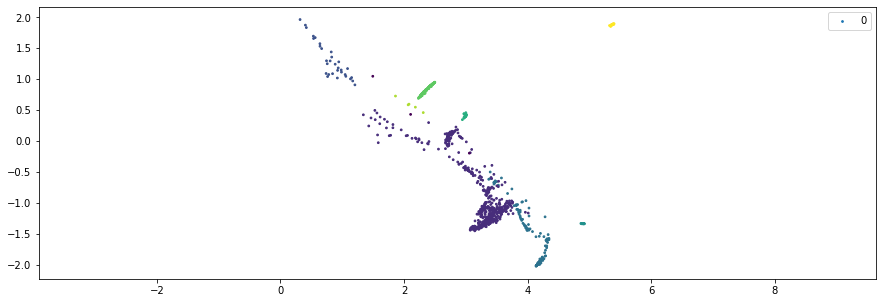

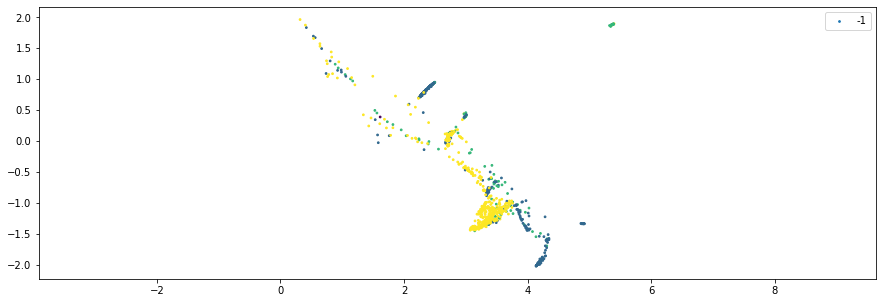

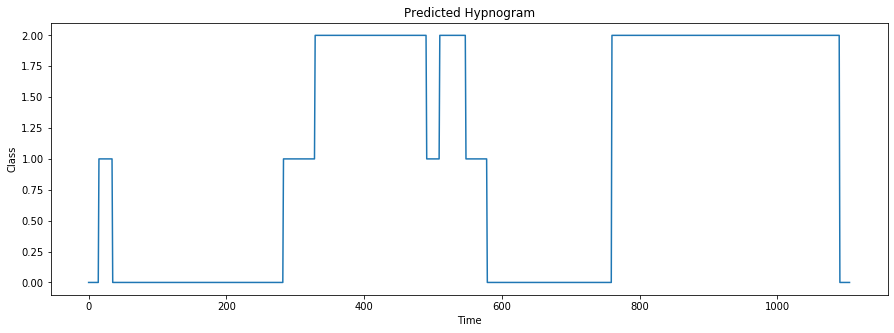

In [148]:
from sklearn.metrics import adjusted_rand_score
clf = sleep_clustering()                       
clf.plot_projection(test_3,test_4.labels_)
clf.plot_projection(test_3,y_test[:,0])
clf.plot_hypnogram(test_4.labels_)
clf.plot_hypnogram(y_test)
print('Score = '+str(adjusted_rand_score(y_test[:,0],test_4.labels_)))

# Learning on test set alone

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='euclidean',
     metric_kwds=None, min_dist=0.0, n_components=2, n_epochs=None,
     n_neighbors=50, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=0.5, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 14 17:00:13 2020 Finding Nearest Neighbors
Tue Jul 14 17:00:13 2020 Finished Nearest Neighbor Search
Tue Jul 14 17:00:13 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  3

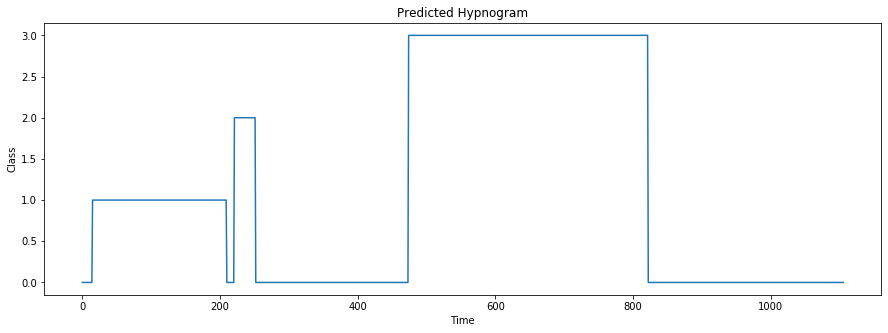

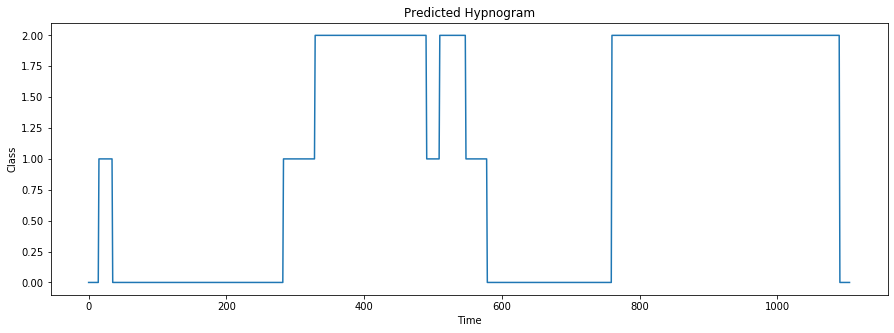

In [49]:
# ignore - test umap on one test session alone
test_umap = umap.UMAP(n_neighbors=umap_n_neighbors,
                         min_dist=umap_min_dist,
                         spread=umap_spread,
                         n_components=umap_n_components,
                         random_state=random_state,
                         low_memory=True,
                         verbose=True)      
test_db = DBSCAN(eps=dbscan_eps,min_samples=dbscan_min_samples)
test_S3 = test_umap.fit_transform(np.mean(x_test,axis=1)) 
test_S4 = db.fit(test_S3)
clf.plot_projection(test_S3,test_S4.labels_) #y_test[:,0])
clf.plot_hypnogram(test_S4.labels_)
clf.plot_hypnogram(y_test)

# Upsamling the labels...

In [8]:
#Collect training data - labeled
sessionNames_list = df.index.levels[0]
x_data = np.empty((0, 121), int)
y_data = np.empty((0, 1), int)
train_ids = [1,2,3,4,5]
for idx in train_ids:
   
    sessionName = sessionNames_list[idx]
    print(f"sessionName:{sessionName}", end =" ") 

    samples = filter_by(df,{'sessionName' : [sessionName]})
    timestamp = samples.reset_index().timestamp
    samples = samples.to_numpy()
    samples = pd.DataFrame(data=samples,index=timestamp)

    print(f"data:{samples.shape}", end =" ") 
    

    labels = filter_by(label_df,{'sessionName' : [sessionName]}).reset_index()
    hypno = labels.y
    hypno_ts = labels.timestamp
    hypno.index = list(labels.timestamp)
    
    hypno_val = hypno.replace(['U','W','R','N2','N3'],[-1,3,2,1,0])
    hypno_upsampled = list(np.repeat(list([hypno_val]), 15))
    print(f"hypno_val:{len(hypno_upsampled)}")

    start = np.round((hypno_ts[0]-timestamp[0])/1000).astype(int)
    if (start>0):    
        samples=samples[start-15:]
        
    #if (samples.shape[0]/window_size!=0):
        end = len(hypno_upsampled) #int(samples.shape[0]/window_size)*window_size
        samples=samples[:end]
        
    samples = samples.to_numpy()
    x_data = np.vstack((x_data,samples))
    y_data = np.vstack((y_data,np.asarray(hypno_upsampled).reshape(-1,1)))

print('X:',x_data.shape)    
print('y:',y_data.shape)

sessionName:2019-07-22-19-34-39 data:(29394, 121) hypno_val:29370
sessionName:2019-07-22-19-58-50 data:(14767, 121) hypno_val:14745
sessionName:2019-07-22-20-10-03 data:(16984, 121) hypno_val:16965
sessionName:2019-07-23-19-32-23 data:(31603, 121) hypno_val:31575
sessionName:2019-07-23-23-10-19 data:(15993, 121) hypno_val:15975
X: (108630, 121)
y: (108630, 1)


In [9]:
#Collect training data - unlabeled
sessionNames_list = unlabeled_df.index.levels[0]
train_ids = [0,1,2,3,4,5,6]
for idx in train_ids:
   
    sessionName = sessionNames_list[idx]
    print(f"sessionName:{sessionName}", end =" ") 

    samples = filter_by(unlabeled_df,{'sessionName' : [sessionName]})
    timestamp = samples.reset_index().timestamp
    samples = samples.to_numpy()
    samples = pd.DataFrame(data=samples,index=timestamp)

    print(f"data:{samples.shape}") 
    
    start = 0
    if (start>0):    
        samples=samples[start:]
        
    #if (samples.shape[0]/window_size!=0):
        end = int(samples.shape[0]/window_size)*window_size
        samples=samples[:end]
        
    samples = samples.to_numpy()
    x_data = np.vstack((x_data,samples))
    labels = list(np.repeat(list([-1]), len(samples)))
    y_data = np.vstack((y_data,np.asarray(labels).reshape(-1,1)))
print('X:',x_data.shape)    
print('y:',y_data.shape)

sessionName:2019-08-17-19-17-01 data:(29650, 121)
sessionName:2019-08-17-22-49-11 data:(17148, 121)
sessionName:2019-08-18-20-07-11 data:(26051, 121)
sessionName:2019-08-18-20-38-22 data:(23084, 121)
sessionName:2019-08-19-20-44-45 data:(27619, 121)
sessionName:2019-08-22-19-16-00 data:(32734, 121)
sessionName:2019-08-27-20-56-05 data:(23778, 121)
X: (288694, 121)
y: (288694, 1)


In [10]:
#collect test data
sessionNames_list = df.index.levels[0]
x_test = np.empty((0, 121), int)
y_test = np.empty((0, 1), int)
test_id=[0]
for idx in test_id:
   
    sessionName = sessionNames_list[idx]
    print(f"sessionName:{sessionName}", end =" ") 

    samples = filter_by(df,{'sessionName' : [sessionName]})
    timestamp = samples.reset_index().timestamp
    samples = samples.to_numpy()
    samples = pd.DataFrame(data=samples,index=timestamp)

    print(f"data:{samples.shape}", end =" ") 
    

    labels = filter_by(label_df,{'sessionName' : [sessionName]}).reset_index()
    hypno = labels.y
    hypno_ts = labels.timestamp
    hypno.index = list(labels.timestamp)

    hypno_val = hypno.replace(['U','W','R','N2','N3'],[-1,3,2,1,0])
   
    print(f"hypno_val:{len(hypno_upsampled)}")

    start = np.round((hypno_ts[0]-timestamp[0])/1000).astype(int)
    if (start>0):    
        samples=samples[start-15:]
        
    #if (samples.shape[0]/window_size!=0):
        end = len(hypno_upsampled) #int(samples.shape[0]/window_size)*window_size
        samples=samples[:end]
        
    samples = samples.to_numpy()
    x_test = np.vstack((x_test,samples))
    y_test = np.vstack((y_test,np.asarray(hypno_upsampled).reshape(-1,1)))
print('X:',x_test.shape)    
print('y:',y_test.shape)

sessionName:2019-07-17-21-39-40 data:(16621, 121) hypno_val:15975
X: (15975, 121)
y: (15975, 1)


In [11]:
#training parameters:
pca_components = -1
remove_pc = False
umap_min_dist = 0.1
umap_spread = 0.5
umap_n_neighbors = 100
umap_n_components = 10
umap_low_memory = True
umap_output_metric='euclidean'
umap_target_weight=0.5
dbscan_eps = 0.5
dbscan_min_samples = 5
random_state = 42;
params = [pca_components,remove_pc,umap_min_dist,umap_n_neighbors,umap_n_components,umap_low_memory,dbscan_eps,dbscan_min_samples,random_state]

In [15]:
#fit on training data
pca = PCA(n_components=pca_components)
umap_reducer = cumlUMAP(n_neighbors=umap_n_neighbors,
                         min_dist=umap_min_dist,
                         spread=umap_spread,
                         n_components=umap_n_components,
                         random_state=random_state,
                         target_metric=umap_output_metric,
                         target_weights=umap_target_weight,
                         #low_memory=True,
                         verbose=True)   
db = DBSCAN(eps=dbscan_eps,min_samples=dbscan_min_samples)

if pca_components>0:
    S1 = pca.fit_transform(x_data)
else:
    S1 = x_data
if remove_pc:
    S2 = S1[:,1:]
else:
    S2 = S1
#S3 = umap_reducer.fit_transform(x_data.reshape(x_data.shape[0],3630),y=y_data[:,0]) 

x_tmp = S2
y_tmp = y_data[:,0]

S3 = umap_reducer.fit_transform(x_tmp[::30],y_tmp[::30]) 
S4 = db.fit(S3)

RuntimeError: Exception occured! file=/rapids/cuml/cpp/src_prims/common/cudart_utils.h line=56: FAIL: call='cudaMemcpyAsync(dst, src, len * sizeof(Type), cudaMemcpyDefault, stream)'. Reason:an illegal memory access was encountered
Obtained 64 stack frames
#0 in /opt/conda/envs/rapids/lib/libcuml++.so(_ZN8MLCommon9Exception16collectCallStackEv+0x3e) [0x7f871439960e]
#1 in /opt/conda/envs/rapids/lib/libcuml++.so(_ZN8MLCommon9ExceptionC2ERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE+0x71) [0x7f871439a181]
#2 in /opt/conda/envs/rapids/lib/libcuml++.so(_ZN8MLCommon6Sparse17csr_add_calc_indsIfLi32EEEmPKiS3_PKT_iS3_S3_S6_iiPiSt10shared_ptrINS_15deviceAllocatorEEP11CUstream_st+0x541) [0x7f8714759ef1]
#3 in /opt/conda/envs/rapids/lib/libcuml++.so(_ZN8UMAPAlgo10Supervised35general_simplicial_set_intersectionIfLi256EEEvPiPN8MLCommon6Sparse3COOIT_iEES2_S8_S8_fSt10shared_ptrINS3_15deviceAllocatorEEP11CUstream_st+0x163) [0x7f8714754113]
#4 in /opt/conda/envs/rapids/lib/libcuml++.so(_ZN8UMAPAlgo10Supervised28perform_general_intersectionILi256EfEEvRKN2ML10cumlHandleEPT0_PN8MLCommon6Sparse3COOIS6_iEESC_PNS2_10UMAPParamsEP11CUstream_st+0x940) [0x7f871474f760]
#5 in /opt/conda/envs/rapids/lib/libcuml++.so(_ZN8UMAPAlgo4_fitIfLi256EEEvRKN2ML10cumlHandleEPT_S6_iiPlS6_PNS1_10UMAPParamsES6_+0x4e2) [0x7f871473df42]
#6 in /opt/conda/envs/rapids/lib/python3.7/site-packages/cuml/manifold/umap.cpython-37m-x86_64-linux-gnu.so(+0x1355a) [0x7f8706f5e55a]
#7 in /opt/conda/envs/rapids/bin/python(PyObject_Call+0xb4) [0x5641066fb214]
#8 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalFrameDefault+0x1ccd) [0x5641067a4b8d]
#9 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalCodeWithName+0x7cd) [0x5641066f9a7d]
#10 in /opt/conda/envs/rapids/bin/python(_PyObject_FastCallDict+0x5be) [0x5641066faebe]
#11 in /opt/conda/envs/rapids/bin/python(+0x12f071) [0x56410670f071]
#12 in /opt/conda/envs/rapids/lib/python3.7/site-packages/cuml/manifold/umap.cpython-37m-x86_64-linux-gnu.so(+0x10a8f) [0x7f8706f5ba8f]
#13 in /opt/conda/envs/rapids/bin/python(_PyObject_FastCallKeywords+0x15c) [0x564106760bec]
#14 in /opt/conda/envs/rapids/bin/python(+0x181661) [0x564106761661]
#15 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalFrameDefault+0x48a2) [0x5641067a7762]
#16 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalCodeWithName+0x255) [0x5641066f9505]
#17 in /opt/conda/envs/rapids/bin/python(+0x1d7525) [0x5641067b7525]
#18 in /opt/conda/envs/rapids/bin/python(_PyMethodDef_RawFastCallKeywords+0xe9) [0x564106729789]
#19 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalFrameDefault+0x4568) [0x5641067a7428]
#20 in /opt/conda/envs/rapids/bin/python(+0x180434) [0x564106760434]
#21 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalFrameDefault+0x19aa) [0x5641067a486a]
#22 in /opt/conda/envs/rapids/bin/python(+0x180434) [0x564106760434]
#23 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalFrameDefault+0x19aa) [0x5641067a486a]
#24 in /opt/conda/envs/rapids/bin/python(+0x180434) [0x564106760434]
#25 in /opt/conda/envs/rapids/bin/python(_PyMethodDescr_FastCallKeywords+0xdb) [0x5641067607cb]
#26 in /opt/conda/envs/rapids/bin/python(+0x18153e) [0x56410676153e]
#27 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalFrameDefault+0x611) [0x5641067a34d1]
#28 in /opt/conda/envs/rapids/bin/python(_PyFunction_FastCallKeywords+0x187) [0x564106718d37]
#29 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalFrameDefault+0x3f5) [0x5641067a32b5]
#30 in /opt/conda/envs/rapids/bin/python(_PyFunction_FastCallKeywords+0x187) [0x564106718d37]
#31 in /opt/conda/envs/rapids/bin/python(+0x181455) [0x564106761455]
#32 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalFrameDefault+0x611) [0x5641067a34d1]
#33 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalCodeWithName+0x255) [0x5641066f9505]
#34 in /opt/conda/envs/rapids/bin/python(_PyObject_FastCallDict+0x5be) [0x5641066faebe]
#35 in /opt/conda/envs/rapids/bin/python(+0x12f071) [0x56410670f071]
#36 in /opt/conda/envs/rapids/bin/python(PyObject_Call+0xb4) [0x5641066fb214]
#37 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalFrameDefault+0x1ccd) [0x5641067a4b8d]
#38 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalCodeWithName+0x7cd) [0x5641066f9a7d]
#39 in /opt/conda/envs/rapids/bin/python(_PyFunction_FastCallKeywords+0x583) [0x564106719133]
#40 in /opt/conda/envs/rapids/bin/python(+0x181455) [0x564106761455]
#41 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalFrameDefault+0x1411) [0x5641067a42d1]
#42 in /opt/conda/envs/rapids/bin/python(+0x192945) [0x564106772945]
#43 in /opt/conda/envs/rapids/bin/python(_PyMethodDef_RawFastCallKeywords+0xe9) [0x564106729789]
#44 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalFrameDefault+0x4568) [0x5641067a7428]
#45 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalCodeWithName+0x7cd) [0x5641066f9a7d]
#46 in /opt/conda/envs/rapids/bin/python(_PyFunction_FastCallKeywords+0x583) [0x564106719133]
#47 in /opt/conda/envs/rapids/bin/python(+0x181455) [0x564106761455]
#48 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalFrameDefault+0x611) [0x5641067a34d1]
#49 in /opt/conda/envs/rapids/bin/python(+0x192945) [0x564106772945]
#50 in /opt/conda/envs/rapids/bin/python(_PyMethodDef_RawFastCallKeywords+0xe9) [0x564106729789]
#51 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalFrameDefault+0x4568) [0x5641067a7428]
#52 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalCodeWithName+0x7cd) [0x5641066f9a7d]
#53 in /opt/conda/envs/rapids/bin/python(_PyFunction_FastCallKeywords+0x583) [0x564106719133]
#54 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalFrameDefault+0x3f5) [0x5641067a32b5]
#55 in /opt/conda/envs/rapids/bin/python(+0x192945) [0x564106772945]
#56 in /opt/conda/envs/rapids/bin/python(_PyMethodDef_RawFastCallKeywords+0xe9) [0x564106729789]
#57 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalFrameDefault+0x4568) [0x5641067a7428]
#58 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalCodeWithName+0x7cd) [0x5641066f9a7d]
#59 in /opt/conda/envs/rapids/bin/python(_PyObject_FastCallDict+0x316) [0x5641066fac16]
#60 in /opt/conda/envs/rapids/bin/python(+0x12f071) [0x56410670f071]
#61 in /opt/conda/envs/rapids/bin/python(PyObject_Call+0xb4) [0x5641066fb214]
#62 in /opt/conda/envs/rapids/bin/python(_PyEval_EvalFrameDefault+0x1ccd) [0x5641067a4b8d]
#63 in /opt/conda/envs/rapids/bin/python(+0x180434) [0x564106760434]


In [17]:
x_tmp[::30].shape


(9624, 121)

In [19]:
y_data[:,0].shape

(288694,)

In [12]:
if pca_components>0:
    test_1 = pca.transform(x_test)
else:
    test_1 = x_test
if remove_pc:
    test_2 = test_1[:,1:]
else:
    test_2 = test_1
test_3 = umap_reducer.transform(test_2)
test_4 = db.fit(test_3)

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs


Score = 0.00023789952146222246


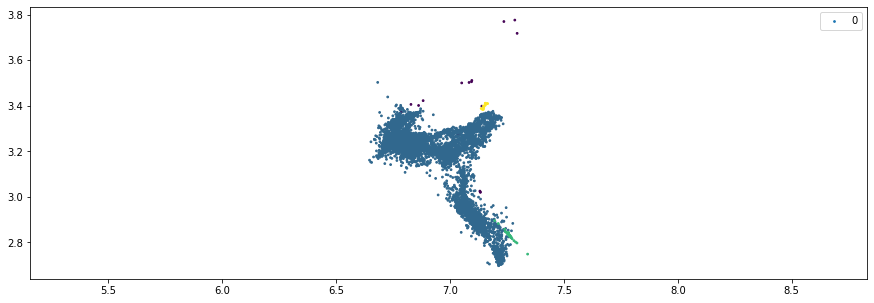

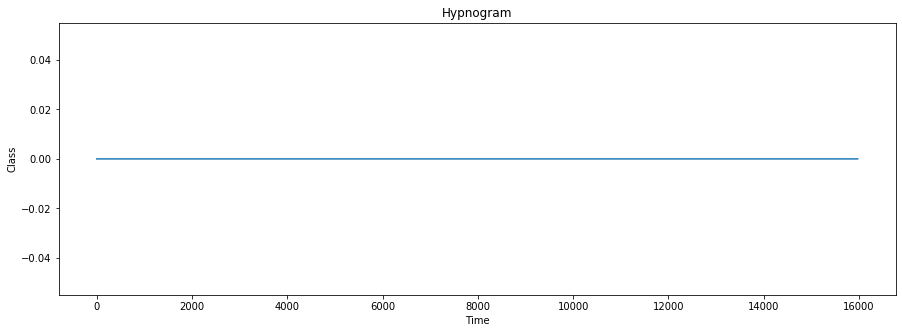

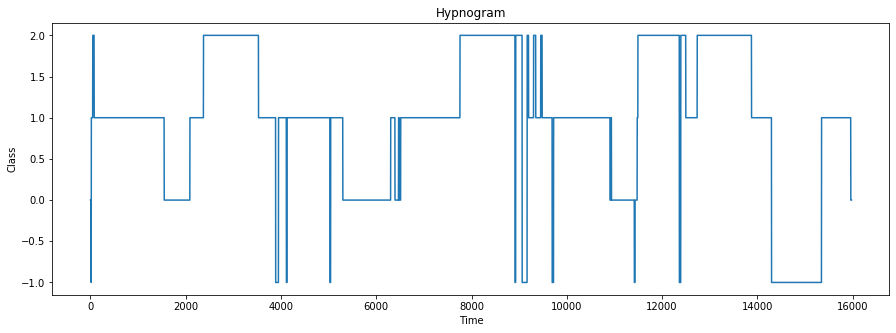

In [13]:
from sklearn.metrics import adjusted_rand_score
clf = sleep_clustering()                       
clf.plot_projection(test_3,test_4.labels_)
clf.plot_projection(test_3,y_test[:,0])
clf.plot_hypnogram(test_4.labels_)
clf.plot_hypnogram(y_test)
print('Score = '+str(adjusted_rand_score(y_test[:,0],test_4.labels_)))

In [17]:
import cuml
cuml.__version__

'0+untagged.1.g807094c'